# Overlapping Community Summary

#### Imports

In [1]:
from typing import Dict, List, Tuple, Optional, Callable, Set 
from collections import namedtuple
import os
from functional import seq, pseq
from functional.streams import Sequence
from IPython.core.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
import wordcloud as wc

def display_seq(sequence:Sequence,rows:int)-> None:
        sequence._repr_html_= lambda :sequence.tabulate(rows,tablefmt='html')
        display(sequence)
        sequence._repr_html_= lambda :sequence.tabulate(10,tablefmt='html')
plt.rcParams['figure.figsize'] = [15, 8]

In [2]:
import functools
def compose(*functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions, lambda x: x)

In [3]:
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

In [4]:
from util import get_envs, cached_load
base_dir = get_envs()["base_dir"]
overlap_dir = base_dir + 'overlap/'
base_dir,overlap_dir

('/home/owner/blob/data/data_mining/dblp/csv/',
 '/home/owner/blob/data/data_mining/dblp/csv/overlap/')

In [5]:
from py2neo import Graph,Node
graph = Graph("bolt://127.0.0.1:7687",auth=("neo4j", "admin"))

# Preparing data for overlapping infomap

In [6]:
query = """Match (sourceNode:person {key: "marcin kurdziel_pers"})
  With sourceNode
  Match path = (sourceNode) -[:COAUTHORS_WITH*1..4]-(destNode:person)
   return destNode.key as key"""

In [9]:
friends = pd.DataFrame.from_dict(graph.run(query).data()).drop_duplicates()
friends.head()

key
0  krzysztof boryczko_pers
1      a. leszczynski_pers
2      jacek kitowski_pers
3         ales tavcar_pers
4         alina mylka_pers

In [10]:
len(friends)

393202

In [11]:
f_set = set(friends.key)

In [12]:
base_dir

'/home/owner/blob/data/data_mining/dblp/csv/'

In [13]:
coauthorships = pd.read_csv(base_dir + 'coauthorships.csv',header=None, names= ["a_key", "b_key", "count"])

In [14]:
coauthorships.head()

a_key           b_key  count
0       (david) jing dai_pers  gengen he_pers      1
1       (david) jing dai_pers   song gao_pers      1
2       (david) jing dai_pers   xin chen_pers      1
3       (david) jing dai_pers    yang xu_pers      1
4  (max) zong-ming cheng_pers    bin cai_pers      1

In [15]:
filtered = coauthorships.where(coauthorships.a_key.isin(f_set) & coauthorships.b_key.isin(f_set)).dropna()

In [19]:
print(100* filtered['count'].sum() / coauthorships['count'].sum())

41.33224633054765


In [39]:
filtered.to_csv(overlap_dir + "/kurdziel_friends4.csv", index=False,header=False)

## import igraph as ig

In [22]:
friend_graph = ig.Graph.TupleList(seq(filtered).to_list(),weights=True,vertex_name_attr='id')

NameError: name 'ig' is not defined

In [31]:
friend_graph.write_pajek(base_dir + 'kurdziel_friends_4.net')

In [220]:
base_dir
!ls ~/blob/data/data_mining/dblp/csv

authored.csv	    graph.7z		    kurdziel_friends_4.tree
cited.csv	    infomap_major	    multilevel
coauthorships.csv   infomap_minor	    persons.csv
coauthorships.net   in_venue.csv	    publications.csv
coauthorships.tree  kurdziel_friends_4.net  venues.csv


# Parsing Infomap results

In [227]:
!tail -n +3 < ~/blob/data/data_mining/dblp/csv/kurdziel_friends_4.tree >   kur4_trimmed.tree
!ls

CommunityGraphs.ipynb	impl.org	   Preprocessing.ipynb	util.py
CommunitySummary.ipynb	infomap_query.sh   __pycache__
docker			kur4_trimmed.tree  Random.ipynb
img			Overview.ipynb	   scala-app


In [223]:
# !tail -n +3 < kurdziel_friends_4.tree | awk -F' ' '{print $4}' | sort -g |uniq -c| sort -gr | head -n 10

Now `./Infomap --overlaping ./kurdziel_friends_4.net .` 

In [16]:
name_community = pd.read_csv("./kur4_trimmed.tree",sep=" ", header=None,names=["path", "sth", "name","key"])

In [17]:
name_community.path = name_community.path.apply(lambda x : ":".join(x.split(":")[:3]) )
# friends = friends.drop(['sth','name'],axis=1).drop_duplicates()

In [18]:
name_community.head()

path       sth                   name   key
0  1:1:1  0.006165  jack j. dongarra_pers    90
1  1:1:2  0.001551   stanimire tomov_pers   408
2  1:1:3  0.001306    piotr luszczek_pers   407
3  1:1:4  0.001226    george bosilca_pers  6188
4  1:1:5  0.000880      jakub kurzak_pers   406

In [19]:
key_to_name = seq(name_community[['key','name']]).to_dict()
key_to_name[90]

'jack j. dongarra_pers'

In [20]:
friends = name_community.drop(['sth','name'],axis=1).drop_duplicates()

In [21]:
friends.head()

path   key
0  1:1:1    90
1  1:1:2   408
2  1:1:3   407
3  1:1:4  6188
4  1:1:5   406

In [22]:
tab = seq(friends.path).map(lambda x: seq(x.split(":")).map(int).to_list()).to_pandas(columns= ['major', 'minor','tiny'])
major_max = tab.major.max()
minor_max = tab.minor.max()
tiny_max = tab.tiny.max()
print(major_max,minor_max,tiny_max)


24 358 261


In [23]:
def path_to_uniq_int_index(path:str) -> int :
    major,minor,tiny = list(path.split(":"))
    return tiny + (minor + major_max * major) * minor_max

In [24]:
friends['path_key'] = friends.path.apply(path_to_uniq_int_index)

Sanity check - is path_to_uniq_int_index unique?

In [25]:
friends.where(friends.path.drop_duplicates().apply(path_to_uniq_int_index).duplicated()).dropna()

Empty DataFrame
Columns: [path, key, path_key]
Index: []

In [26]:
friends = friends.drop(['path_key'],axis=1)
f = friends.groupby('key').agg('count').reset_index()

In [27]:
f.head()

key  path
0    1     2
1    2     1
2    3     1
3    4     4
4    5     1

In [28]:
f.columns = ["person_key", "community_count"]
f = f.sort_values('community_count' ,ascending= False)
f.head()

person_key  community_count
2177        2178               52
2208        2209               41
3196        3197               41
2643        2644               38
2968        2969               37

In [63]:
def plot_label_communites(data,bins=100,title = 'Community size',logscale = True):
    n, bins, patches = plt.hist(data,bins=bins,  facecolor='pink', log=logscale,)
    plt.xlabel(title)
    plt.ylabel('Count')
    if(logscale):
        plt.yscale('log')
    plt.show()

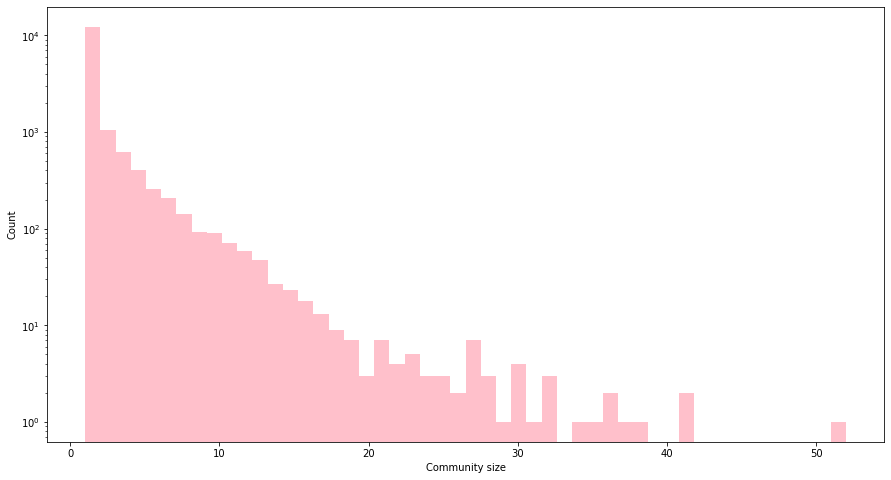

In [64]:
plot_label_communites(f.community_count,bins = 50)

In [41]:
f.community_count.quantile([0.6,0.7,0.8,0.9,0.99,0.999,1])

0.600     1.0
0.700     2.0
0.800     3.0
0.900     4.0
0.990    13.0
0.999    30.0
1.000    52.0
Name: community_count, dtype: float64

In [33]:
person_communities = seq(friends)\
.group_by(lambda path_key: path_key[1])\
.map(lambda key_path_keys: 
     (
         key_path_keys[0],
         seq(key_path_keys[1]).map(lambda a: a[0]).to_list()
     )).to_pandas(columns = ['key','communities'])
person_communities.head(n=2)

key communities
0   90     [1:1:1]
1  408     [1:1:2]

## Plotting communnity intersection

In [34]:
community_members = seq(friends)\
.group_by(lambda path_key: path_key[0])\
.map(lambda path_path_keys: 
     (
         path_path_keys[0],
         seq(path_path_keys[1]).map(lambda a: a[1]).to_set()
     )).to_pandas(columns = ['community','members'])
big_community_members = community_members.where(community_members.members.apply(len) > 15).dropna()
big_community_members['size'] = big_community_members.members.apply(len)

print(len(big_community_members))
big_community_members.head(n=2)

31


community                                            members  size
2855    1:22:1  {1153, 1154, 8447, 1155, 2545, 14216, 14604, 1...    42
2856    1:22:2  {7680, 13312, 13313, 14466, 5127, 14216, 5255,...    47

In [35]:
community_pairs = cartesian_product_basic(big_community_members, big_community_members)
community_pairs= community_pairs\
.where(
    community_pairs.community_x.apply(path_to_uniq_int_index) < community_pairs.community_y.apply(path_to_uniq_int_index)
).dropna()
print("community pair length : ", len(community_pairs))
community_pairs.head(n=1)

community pair length :  465


community_x                                          members_x  size_x  \
1      1:22:1  {1153, 1154, 8447, 1155, 2545, 14216, 14604, 1...    42.0   

  community_y                                          members_y  size_y  
1      1:22:2  {7680, 13312, 13313, 14466, 5127, 14216, 5255,...    47.0

In [36]:
intersetcting_pairs = seq(community_pairs).map(lambda x: list(x) + [x[1].intersection(x[-2])]).to_pandas(columns = list(community_pairs.columns) + ["intersection"])
intersetcting_pairs['intersection_size'] = intersetcting_pairs.intersection.apply(len)
intersetcting_pairs = intersetcting_pairs.sort_values('intersection_size',ascending = False)
intersetcting_pairs.head(n=10)

community_x                                          members_x  size_x  \
268       5:1:1  {7047, 5896, 10897, 8082, 14618, 14619, 10909,...    36.0   
0        1:22:1  {1153, 1154, 8447, 1155, 2545, 14216, 14604, 1...    42.0   
23       1:22:2  {7680, 13312, 13313, 14466, 5127, 14216, 5255,...    47.0   
63       1:33:1  {10246, 8715, 9873, 1945, 13851, 6300, 13596, ...    51.0   
37       1:30:1  {2688, 4738, 3718, 3719, 7947, 7948, 3725, 475...    52.0   
25       1:22:2  {7680, 13312, 13313, 14466, 5127, 14216, 5255,...    47.0   
24       1:22:2  {7680, 13312, 13313, 14466, 5127, 14216, 5255,...    47.0   
199      2:10:1  {1569, 1570, 8900, 13124, 6566, 1577, 170, 885...    18.0   
456      20:2:1  {4740, 12698, 13609, 13610, 13611, 566, 567, 5...    22.0   
32       1:22:4  {12805, 3717, 5255, 11918, 2193, 7198, 8224, 1...    22.0   

    community_y                                          members_y  size_y  \
268       5:1:2  {10883, 14469, 3463, 7047, 3470, 5902, 5903, 7...    41.0   
0        1:22:2  {7680, 13312, 13313, 14466, 5127, 14216, 5255,...    47.0   
23       1:22:3  {4608, 649, 2698, 11662, 9626, 11299, 3364, 11...    23.0   
63       1:33:2  {12551, 9483, 4365, 4623, 4239, 9873, 12821, 2...    31.0   
37       1:30:2  {7170, 3202, 2053, 7948, 7949, 5908, 4758, 233...    47.0   
25       1:22:5  {3840, 5248, 7040, 3334, 2193, 13990, 10281, 4...    20.0   
24       1:22:4  {12805, 3717, 5255, 11918, 2193, 7198, 8224, 1...    22.0   
199      2:10:2  {9354, 1422, 5526, 5529, 2459, 12572, 1565, 15...    22.0   
456      20:2:2  {4740, 15368, 15369, 8715, 6798, 12699, 4767, ...    24.0   
32       1:22:5  {3840, 5248, 7040, 3334, 2193, 13990, 10281, 4...    20.0   

                                          intersection  intersection_size  
268  {9157, 10854, 7047, 12338, 10866, 3445, 14618,...                  9  
0                     {8513, 14216, 14604, 5086, 7294}                  5  
23                   {11299, 11300, 8778, 13615, 8149}                  5  
63                    {2368, 15178, 9873, 15036, 1757}                  5  
37                            {9191, 7011, 7948, 4711}                  4  
25                                 {3580, 13924, 3581}                  3  
24                                       {12994, 5255}                  2  
199                                      {3025, 10039}                  2  
456                                        {4740, 574}                  2  
32                                        {2193, 4933}                  2

In [42]:
df = intersetcting_pairs[['size_x','size_y','intersection_size']]
df['intersection_percentage'] = df.intersection_size / (df.size_x + df.size_y - df.intersection_size)

<ipython-input-42-1ee6ecf27739>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['intersection_percentage'] = df.intersection_size / (df.size_x + df.size_y - df.intersection_size)


In [46]:
ala = df[df.intersection_percentage > 0].dropna()

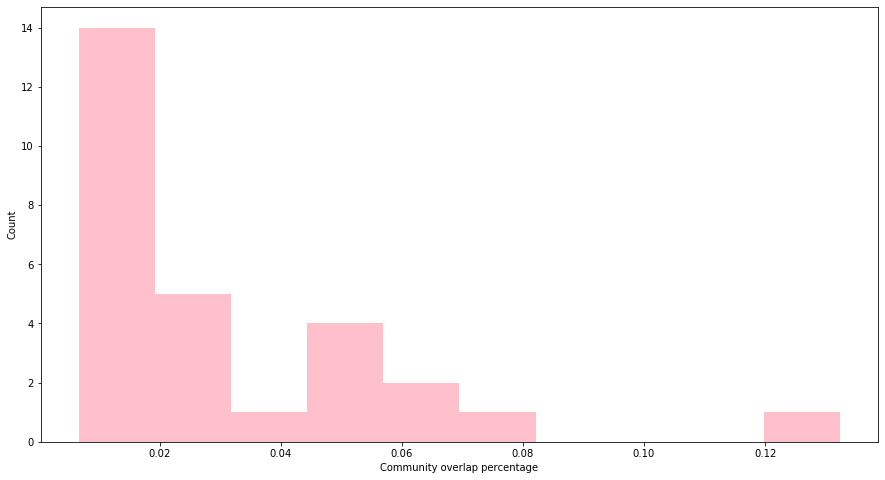

In [66]:
# print(ala.sort_values('intersection_percentage',ascending=False))
plot_label_communites(ala.intersection_percentage,bins=10,title = 'Community overlap percentage', logscale=False)

In [51]:
df.intersection_percentage.quantile([0.5,0.9,0.99])

0.50    0.000000
0.90    0.000000
0.99    0.050947
Name: intersection_percentage, dtype: float64

In [69]:
to_plot = intersetcting_pairs.iloc[0]
to_plot

community_x                                                      5:1:1
members_x            {7047, 5896, 10897, 8082, 14618, 14619, 10909,...
size_x                                                              36
community_y                                                      5:1:2
members_y            {10883, 14469, 3463, 7047, 3470, 5902, 5903, 7...
size_y                                                              41
intersection         {9157, 10854, 7047, 12338, 10866, 3445, 14618,...
intersection_size                                                    9
Name: 268, dtype: object

In [70]:
ids1  = seq(to_plot.members_x).map(lambda x :key_to_name[x]).to_set()
ids2  = seq(to_plot.members_y).map(lambda x :key_to_name[x]).to_set()
intersection_ids = seq(to_plot.intersection).map(lambda x :key_to_name[x]).to_set()

all_ids = ids1.union(ids2)

In [71]:
to_plot_edges = coauthorships.where(coauthorships.a_key.isin(all_ids) & coauthorships.b_key.isin(all_ids)).dropna()
to_plot_edges.head()

a_key                     b_key  count
51684  a. lee swindlehurst_pers  eduard a. jorswieck_pers    1.0
51699  a. lee swindlehurst_pers      h. vincent poor_pers    1.0
51734  a. lee swindlehurst_pers           lifeng lai_pers    1.0
51795  a. lee swindlehurst_pers           walid saad_pers    1.0
51816  a. lee swindlehurst_pers              zhu han_pers    2.0

In [72]:
edges = seq(to_plot_edges).map(lambda row: {"source" :  row[0], "target": row[1], "weight" : row[2] }).to_list()

In [73]:
only1_l = seq(ids1.difference(intersection_ids)).map(lambda x: {"name": x, "community" : "com1"}).to_list()
only2_l = seq(ids2.difference(intersection_ids)).map(lambda x: {"name": x, "community" : "com2"}).to_list()
intersection_l = seq(intersection_ids).map(lambda x: {"name": x, "community" : "intersection"}).to_list()

vertices = only1_l + only2_l + intersection_l

In [39]:
to_plot_graph = ig.Graph.DictList(vertices,edges,directed=False)  #(seq(to_plot_edges).to_list(),weights=True,vertex_name_attr='id')

NameError: name 'ig' is not defined

In [ ]:
to_plot_graph.write_dot(overlap_dir + "community_friends.dot")

# Summarizing

In [74]:
authored = pd.read_csv(base_dir + "authored.csv")
print(authored.columns)

Index(['author_name', 'publication_key'], dtype='object')


In [75]:
publications = pd.read_csv(base_dir + "publications.csv")
print(publications.columns)

Index(['key', 'type', 'title', 'year'], dtype='object')


In [76]:
all_names = seq(friends.key).map(lambda x: key_to_name[x]).to_set()

In [77]:
len(all_names)

15484

In [78]:
community_count = len(friends.path.drop_duplicates())
community_count

31751

In [79]:
all_authorships = authored.where(authored.author_name.isin(all_names)).dropna()
all_authorships = all_authorships.merge(name_community[['path','name']],how='left',left_on = 'author_name',right_on = 'name').drop(['name'],axis=1)
all_authorships.columns= ['person_key', 'publication_key', 'community']

all_authorships.head()

person_key                    publication_key community
0  michael l. heytens_pers  books/acm/kim95/AnnevelinkACFHK95  1:129:29
1  michael l. heytens_pers  books/acm/kim95/AnnevelinkACFHK95  1:141:27
2    josé a. blakeley_pers         books/acm/kim95/Blakeley95   1:3:118
3    josé a. blakeley_pers         books/acm/kim95/Blakeley95  1:35:109
4    josé a. blakeley_pers         books/acm/kim95/Blakeley95   1:95:18

In [80]:
publications.head(n=1)

key  type                                        title  year
0  books/acm/0082477  book  The no-nonsense guide to computing careers.  1992

In [81]:
relevant_publication_keys = seq(all_authorships.publication_key.drop_duplicates()).to_set()
len(relevant_publication_keys) /len(publications)

0.12388754146247334

In [82]:
relevant_publications = publications.where(publications.key.isin(relevant_publication_keys)).dropna()

In [83]:
from nltk.stem.porter import *
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
eng_stop = set(stopwords.words('english'))
stemmer = PorterStemmer()
punctuation_mapping= { ord(c): ' '  for c in string.punctuation}

In [84]:
def generate_relevant_publication_keywords(fn:str) -> pd.DataFrame:
    result = seq(relevant_publications[['key','title']]) \
        .map(
        lambda row : 
        (row[0], list(word_tokenize(row[1].translate(punctuation_mapping).lower())))
        ).to_pandas(columns = ['publication_key','keyword'])
    result.to_json(overlap_dir + fn,index=False,orient='table')
    return result

In [85]:
relevant_publication_keywords_fn = 'relevant_publication_keywords.csv'

relevant_publication_keywords = cached_load(
    relevant_publication_keywords_fn,
    lambda fn:pd.read_json(fn,orient='table'),
    generate_relevant_publication_keywords
)

In [86]:
relevant_publication_keywords.head()

publication_key  \
0  books/acm/kim95/AnnevelinkACFHK95   
1         books/acm/kim95/Blakeley95   
2      books/acm/kim95/BreitbartGS95   
3        books/acm/kim95/DittrichD95   
4            books/acm/kim95/MengY95   

                                             keyword  
0  [object, sql, a, language, for, the, design, a...  
1  [oql, c, extending, c, with, an, object, query...  
2  [transaction, management, in, multidatabase, s...  
3  [where, object, oriented, dbmss, should, do, b...  
4    [query, processing, in, multidatabase, systems]

In [87]:
all_authorships

person_key                    publication_key community
0        michael l. heytens_pers  books/acm/kim95/AnnevelinkACFHK95  1:129:29
1        michael l. heytens_pers  books/acm/kim95/AnnevelinkACFHK95  1:141:27
2          josé a. blakeley_pers         books/acm/kim95/Blakeley95   1:3:118
3          josé a. blakeley_pers         books/acm/kim95/Blakeley95  1:35:109
4          josé a. blakeley_pers         books/acm/kim95/Blakeley95   1:95:18
...                          ...                                ...       ...
2782643        helmut seidl_pers                   tr/trier/MI99-10  11:17:12
2782644        helmut seidl_pers                   tr/trier/MI99-10   14:1:19
2782645      ashok malhotra_pers        www/org/w3/TR/query-algebra   10:38:2
2782646       philip wadler_pers        www/org/w3/TR/query-algebra   8:20:13
2782647       philip wadler_pers        www/org/w3/TR/query-algebra    8:36:1

[2782648 rows x 3 columns]

In [88]:
publication_in_communities = all_authorships[['publication_key','community']].merge(relevant_publication_keywords,on= 'publication_key')[['keyword','community']]

In [89]:
keyword_in_community_count = seq(publication_in_communities)\
.flat_map(lambda x: seq(x[0]).map(lambda a:
                                  (a,x[1])
                                 )).to_pandas(columns=['keyword','community'])
keyword_in_community_count = keyword_in_community_count.drop_duplicates().groupby('keyword',as_index=False).count()
keyword_in_community_count['idf'] = keyword_in_community_count.community.apply(lambda x: np.log(community_count/x))

In [90]:
keyword_in_community_count.head(n=2)

keyword  community       idf
0       0       3656  2.161555
1      00         80  5.983653

In [104]:
def tf_idf(person_ids:Set[str]):
    relevant_pubs = all_authorships.where(all_authorships.person_key.isin(person_ids)).dropna()[['publication_key']].drop_duplicates() #Drop or not drop?
    tf =  seq(relevant_publication_keywords.merge(relevant_pubs,on= 'publication_key')['keyword'])\
    .flat_map(lambda x:seq(x).map(lambda a:(a,1))).\
    count_by_key().to_pandas(columns=['keyword','tf'])
    ala = tf.merge(keyword_in_community_count,on='keyword')[['keyword','tf','idf']]
    ala['tf-idf'] = ala.tf * ala.idf
    return ala.sort_values('tf-idf',ascending=False)

In [105]:
def plot_tf_idf(tidf_df: pd.DataFrame) -> None :
    freqs = seq(tidf_df[['keyword','tf-idf']]).to_dict()
    word_cloud = wc.WordCloud(max_font_size=40,height=400,width=800, background_color= "white")\
    .generate_from_frequencies(freqs)
    plt.figure(figsize=(20,10))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


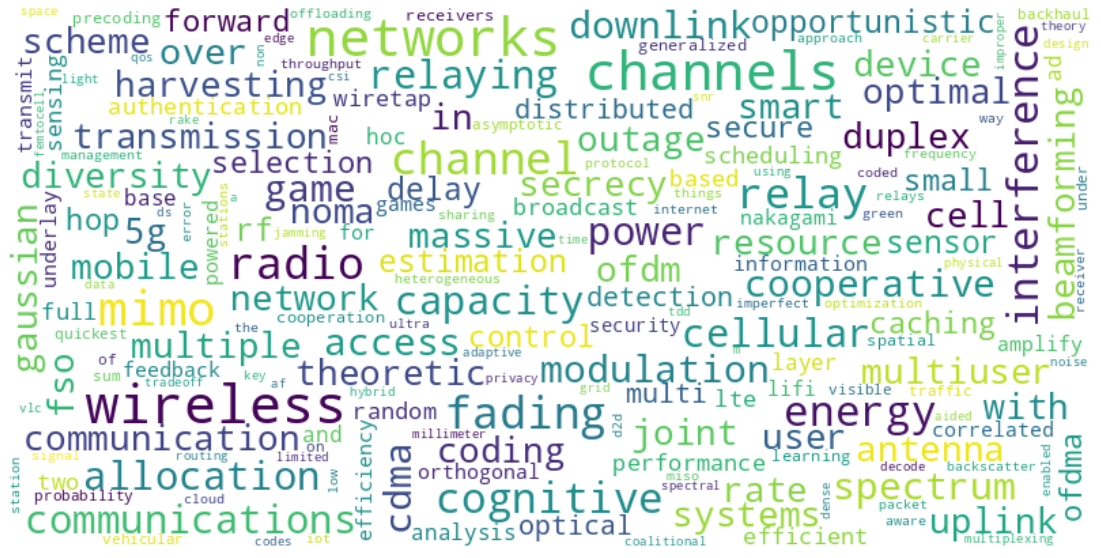

In [106]:
plot_tf_idf(tf_idf(ids1.difference(intersection_ids)))

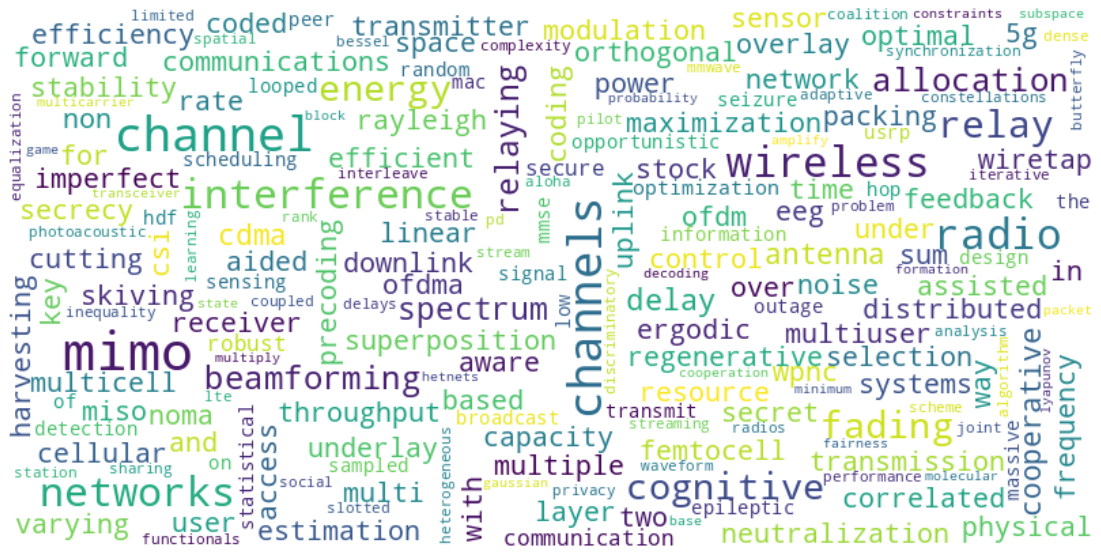

In [107]:
plot_tf_idf(tf_idf(ids2.difference(intersection_ids)))

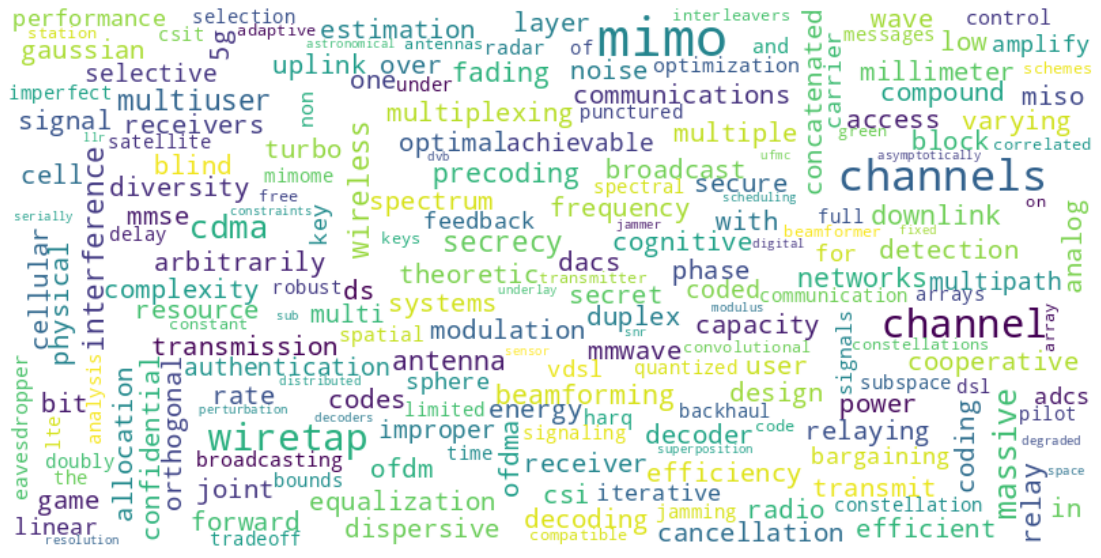

In [108]:
plot_tf_idf(tf_idf(intersection_ids))

## Diffs between communities
Not working well

In [96]:
all_ids_tf_idf = tf_idf(all_ids)
ids1_tf_idf = tf_idf(ids1.difference(intersection_ids))
ids2_tf_idf = tf_idf(ids2.difference(intersection_ids))
intersection_tf_idf = tf_idf(intersection_ids)

In [97]:
def difftf(tf:pd.DataFrame) -> pd.DataFrame:
    
    ela = tf.merge(all_ids_tf_idf,on='keyword')
    ela['tf-idf'] = ela['tf-idf_x'] - ela['tf-idf_y'] + 100
    return ela[['keyword','tf-idf']]

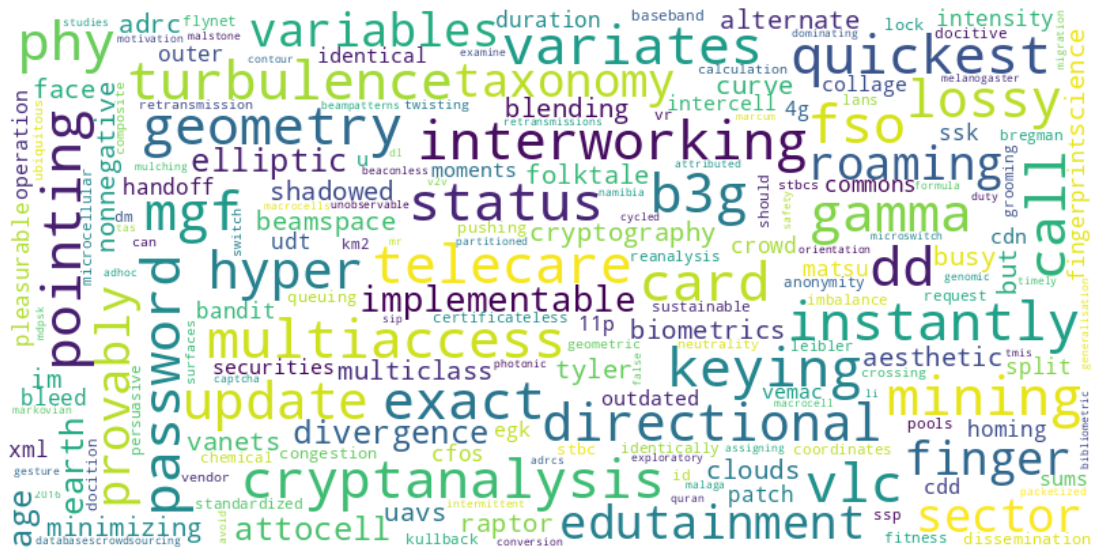

None

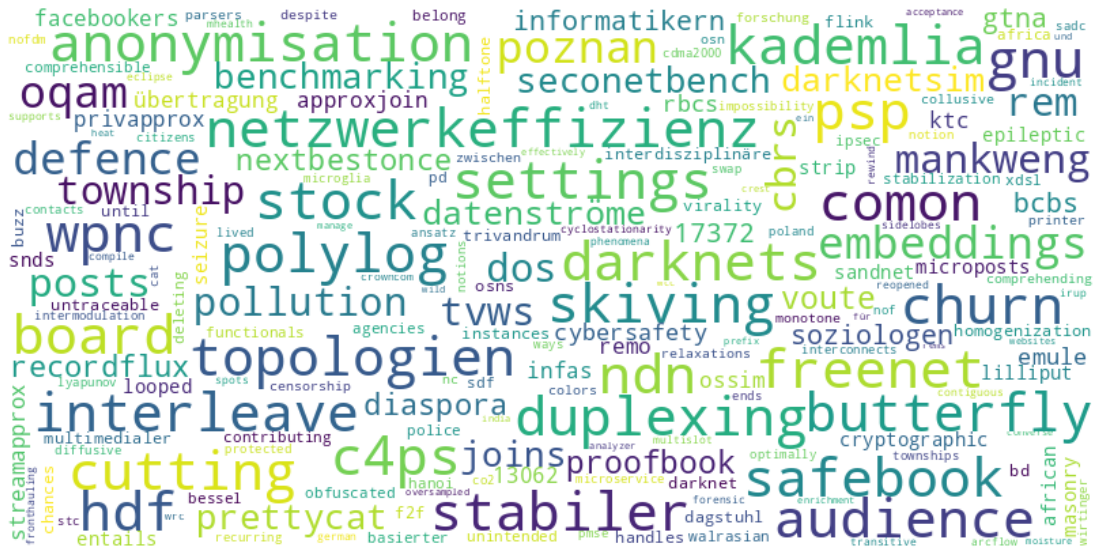

None

AttributeError: 'set' object has no attribute 'merge'

In [98]:
display(plot_tf_idf(difftf(ids1_tf_idf)))
display(plot_tf_idf(difftf(ids2_tf_idf)))
plot_tf_idf(difftf(intersection_ids))

# Diffs v2

In [119]:
def ala_makota(person_ids:Set[str]):
    relevant_pubs = all_authorships.where(all_authorships.person_key.isin(person_ids)).dropna()[['publication_key']].drop_duplicates()
    ala = seq(relevant_publication_keywords.merge(relevant_pubs,on= 'publication_key')['keyword']).flat_map(lambda x: seq(x)).count_by_value().to_pandas(columns= ['kw','cnt'])
    
    return ala.sort_values('cnt',ascending=False)

## One way

In [173]:
t1 = ala_makota(ids1.difference(intersection_ids))
t1b = ala_makota(ids1)
t2 =  ala_makota(ids2.difference(intersection_ids))
t2b =  ala_makota(ids2)
ti =  ala_makota(intersection_ids)
t12 = ala_makota(ids1.union(ids2).difference(intersection_ids))

for t in (t1,t1b,t2,t2b,ti,t12b):
    t['normalized'] = t['cnt'] / t.cnt.sum()
    

In [157]:
def plot_ala(data: pd.DataFrame) -> None :
    freqs = seq(data[['kw','normalized_diff']]).to_dict()
    word_cloud = wc.WordCloud(max_font_size=40,height=400,width=800, background_color= "white")\
    .generate_from_frequencies(freqs)
    plt.figure(figsize=(20,10))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

kw   cnt_x  normalized_x  cnt_y  normalized_y  cnt_diff  \
4        networks  2288.0      0.023613  196.0      0.013875    2092.0   
8        wireless  1225.0      0.012643  121.0      0.008566    1104.0   
10          based   958.0      0.009887   94.0      0.006654     864.0   
22        network   520.0      0.005367   32.0      0.002265     488.0   
28           data   454.0      0.004685   27.0      0.001911     427.0   
27      cognitive   476.0      0.004913   35.0      0.002478     441.0   
47         mobile   325.0      0.003354   17.0      0.001203     308.0   
21          using   521.0      0.005377   46.0      0.003256     475.0   
23          radio   518.0      0.005346   47.0      0.003327     471.0   
55         scheme   267.0      0.002756   11.0      0.000779     256.0   
66         device   236.0      0.002436    8.0      0.000566     228.0   
60     management   261.0      0.002694   13.0      0.000920     248.0   
85          small   177.0      0.001827    1.0      0.000071     176.0   
64          smart   251.0      0.002590   12.0      0.000849     239.0   
34  communication   415.0      0.004283   37.0      0.002619     378.0   
72  heterogeneous   216.0      0.002229    8.0      0.000566     208.0   
53       learning   284.0      0.002931   18.0      0.001274     266.0   
26    distributed   480.0      0.004954   47.0      0.003327     433.0   
83          cloud   183.0      0.001889    4.0      0.000283     179.0   
25         access   498.0      0.005140   50.0      0.003540     448.0   

    normalized_diff  
4          0.009738  
8          0.004077  
10         0.003233  
22         0.003101  
28         0.002774  
27         0.002435  
47         0.002151  
21         0.002121  
23         0.002019  
55         0.001977  
66         0.001869  
60         0.001773  
85         0.001756  
64         0.001741  
34         0.001664  
72         0.001663  
53         0.001657  
26         0.001627  
83         0.001605  
25         0.001600

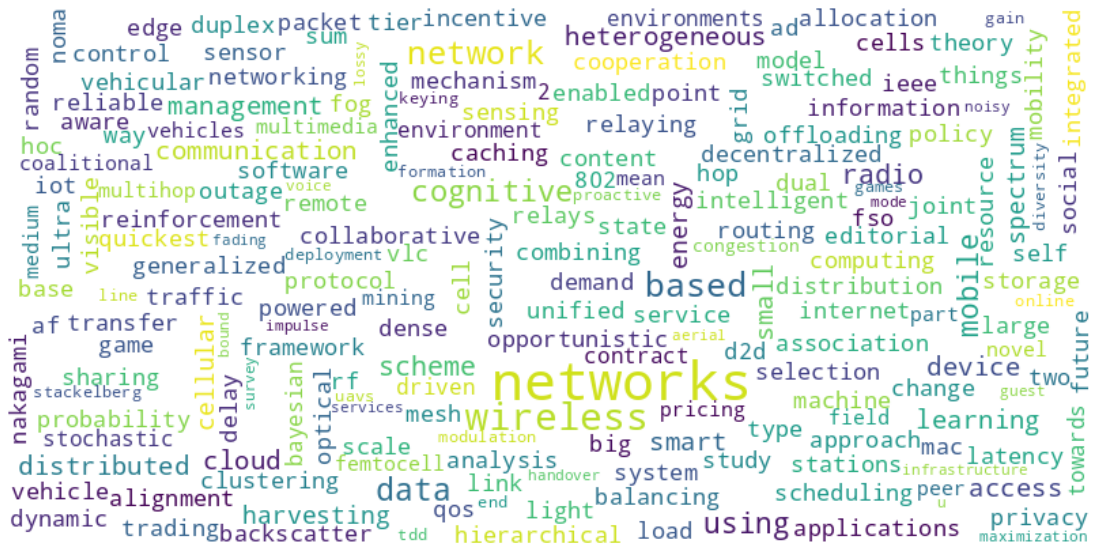

In [159]:
m1 = t1.merge(ti, on = 'kw',how='outer').fillna(0)
m1 = m1.where(~ m1.isin(eng_stop)).dropna()
m1['cnt_diff'] = m1['cnt_x'] - m1['cnt_y']
m1['normalized_diff'] = m1['normalized_x'] - m1['normalized_y']
display(m1.sort_values('normalized_diff',ascending= False).head(n= 20))
plot_ala(m1)

kw  cnt_x  normalized_x  cnt_y  normalized_y  cnt_diff  \
10           based  197.0      0.011400   94.0      0.006654     103.0   
4         networks  318.0      0.018402  196.0      0.013875     122.0   
20       cognitive  102.0      0.005902   35.0      0.002478      67.0   
16           radio  114.0      0.006597   47.0      0.003327      67.0   
23         network   95.0      0.005497   32.0      0.002265      63.0   
14          energy  165.0      0.009548   94.0      0.006654      71.0   
36           delay   64.0      0.003703   19.0      0.001345      45.0   
21            time  101.0      0.005845   52.0      0.003681      49.0   
72       stability   36.0      0.002083    2.0      0.000142      34.0   
24     distributed   91.0      0.005266   47.0      0.003327      44.0   
38        spectrum   62.0      0.003588   26.0      0.001841      36.0   
26        resource   86.0      0.004977   46.0      0.003256      40.0   
50           aware   48.0      0.002778   15.0      0.001062      33.0   
43          system   56.0      0.003241   24.0      0.001699      32.0   
95         problem   27.0      0.001562    4.0      0.000283      23.0   
73        assisted   36.0      0.002083   12.0      0.000849      24.0   
85   heterogeneous   31.0      0.001794    8.0      0.000566      23.0   
100   maximization   26.0      0.001505    4.0      0.000283      22.0   
129           peer   21.0      0.001215    0.0      0.000000      21.0   
126          stock   21.0      0.001215    0.0      0.000000      21.0   

     normalized_diff  
10          0.004745  
4           0.004527  
20          0.003425  
16          0.003270  
23          0.003232  
14          0.002894  
36          0.002358  
21          0.002163  
72          0.001942  
24          0.001939  
38          0.001747  
26          0.001720  
50          0.001716  
43          0.001542  
95          0.001279  
73          0.001234  
85          0.001228  
100         0.001221  
129         0.001215  
126         0.001215

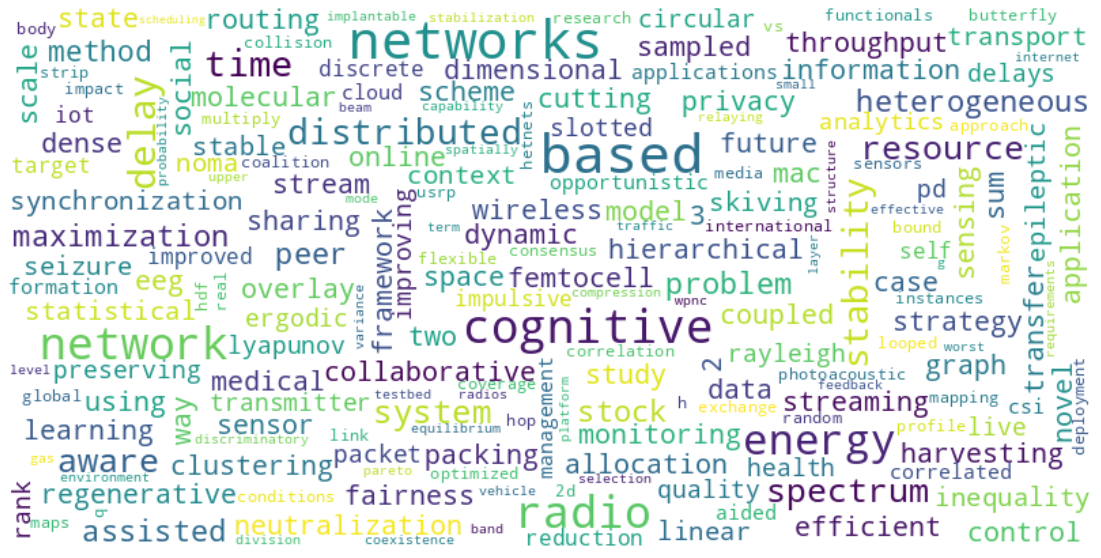

In [160]:
m2 = t2.merge(ti, on = 'kw',how='outer').fillna(0)
m2 = m2.where(~ m2.isin(eng_stop)).dropna()
m2['cnt_diff'] = m2['cnt_x'] - m2['cnt_y']
m2['normalized_diff'] = m2['normalized_x'] - m2['normalized_y']
display(m2.sort_values('normalized_diff',ascending= False).head(n= 20))
plot_ala(m2)

## Other way

kw   cnt_x  normalized_x  cnt_y  normalized_y  cnt_diff  \
4          networks  2459.0      0.022454  502.0      0.016230    1957.0   
8          wireless  1331.0      0.012154  279.0      0.009020    1052.0   
32             data   475.0      0.004337   73.0      0.002360     402.0   
46             game   379.0      0.003461   46.0      0.001487     333.0   
53           mobile   339.0      0.003096   35.0      0.001132     304.0   
42         cellular   408.0      0.003726   63.0      0.002037     345.0   
75           device   244.0      0.002228   20.0      0.000647     224.0   
66            smart   259.0      0.002365   27.0      0.000873     232.0   
25           access   541.0      0.004940  108.0      0.003492     433.0   
36    communication   443.0      0.004045   81.0      0.002619     362.0   
63       management   274.0      0.002502   34.0      0.001099     240.0   
103           small   178.0      0.001625    8.0      0.000259     170.0   
30   communications   481.0      0.004392   95.0      0.003071     386.0   
64           scheme   272.0      0.002484   36.0      0.001164     236.0   
22            using   561.0      0.005123  119.0      0.003847     442.0   
48            joint   352.0      0.003214   60.0      0.001940     292.0   
17         analysis   693.0      0.006328  157.0      0.005076     536.0   
16            power   703.0      0.006419  160.0      0.005173     543.0   
90            cloud   187.0      0.001708   16.0      0.000517     171.0   
123            grid   150.0      0.001370    6.0      0.000194     144.0   

     normalized_diff  
4           0.006225  
8           0.003134  
32          0.001977  
46          0.001974  
53          0.001964  
42          0.001689  
75          0.001581  
66          0.001492  
25          0.001449  
36          0.001427  
63          0.001403  
103         0.001367  
30          0.001321  
64          0.001320  
22          0.001276  
48          0.001274  
17          0.001252  
16          0.001247  
90          0.001190  
123         0.001176

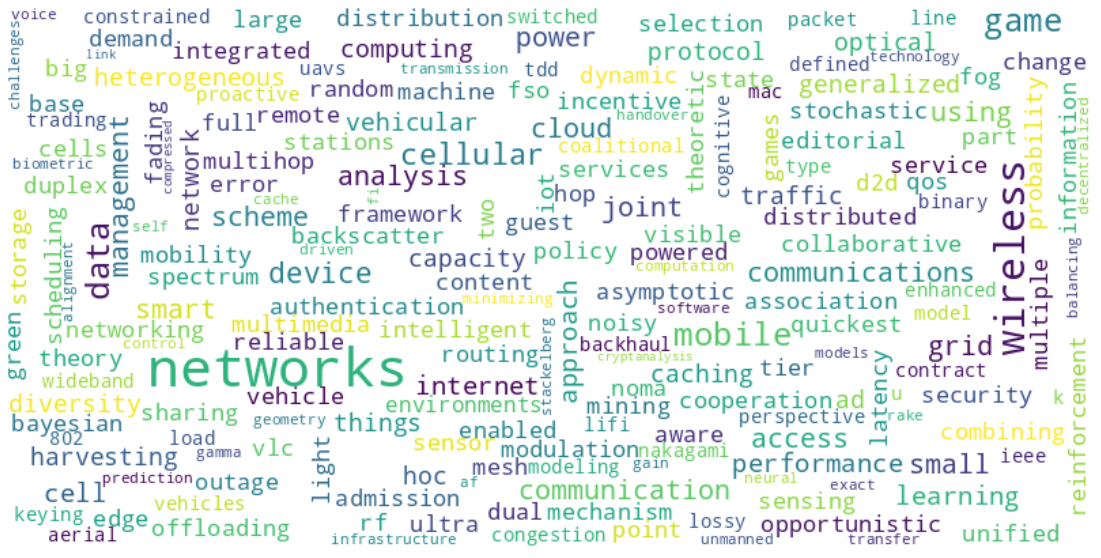

In [166]:
d1 = t1b.merge(t2b, on = 'kw',how='outer').fillna(0)
d1 = d1.where(~ d1.isin(eng_stop)).dropna()
d1['cnt_diff'] = d1['cnt_x'] - d1['cnt_y']
d1['normalized_diff'] = d1['normalized_x'] - d1['normalized_y']
display(d1.sort_values('normalized_diff',ascending= False).head(n= 20))
plot_ala(d1)

kw  cnt_x  normalized_x   cnt_y  normalized_y  cnt_diff  \
7            mimo  452.0      0.014613   861.0      0.007862    -409.0   
10        channel  363.0      0.011736   813.0      0.007424    -450.0   
8         systems  436.0      0.014096  1138.0      0.010392    -702.0   
18     estimation  167.0      0.005399   351.0      0.003205    -184.0   
24           time  153.0      0.004946   314.0      0.002867    -161.0   
54         linear   87.0      0.002813   136.0      0.001242     -49.0   
61        wiretap   79.0      0.002554   113.0      0.001032     -34.0   
12       channels  302.0      0.009764   904.0      0.008255    -602.0   
25         design  146.0      0.004720   357.0      0.003260    -211.0   
46    beamforming   96.0      0.003104   186.0      0.001698     -90.0   
33        massive  126.0      0.004074   308.0      0.002813    -182.0   
50        antenna   92.0      0.002974   188.0      0.001717     -96.0   
70      precoding   71.0      0.002295   115.0      0.001050     -44.0   
17   interference  180.0      0.005819   508.0      0.004639    -328.0   
41           cdma  108.0      0.003492   254.0      0.002319    -146.0   
19      efficient  165.0      0.005334   470.0      0.004292    -305.0   
107       varying   47.0      0.001520    55.0      0.000502      -8.0   
130     stability   38.0      0.001229    24.0      0.000219      14.0   
108           one   47.0      0.001520    62.0      0.000566     -15.0   
95            bit   55.0      0.001778    91.0      0.000831     -36.0   

     normalized_diff  
7           0.006751  
10          0.004312  
8           0.003704  
18          0.002194  
24          0.002079  
54          0.001571  
61          0.001522  
12          0.001509  
25          0.001460  
46          0.001405  
33          0.001261  
50          0.001258  
70          0.001245  
17          0.001181  
41          0.001172  
19          0.001043  
107         0.001017  
130         0.001009  
108         0.000953  
95          0.000947

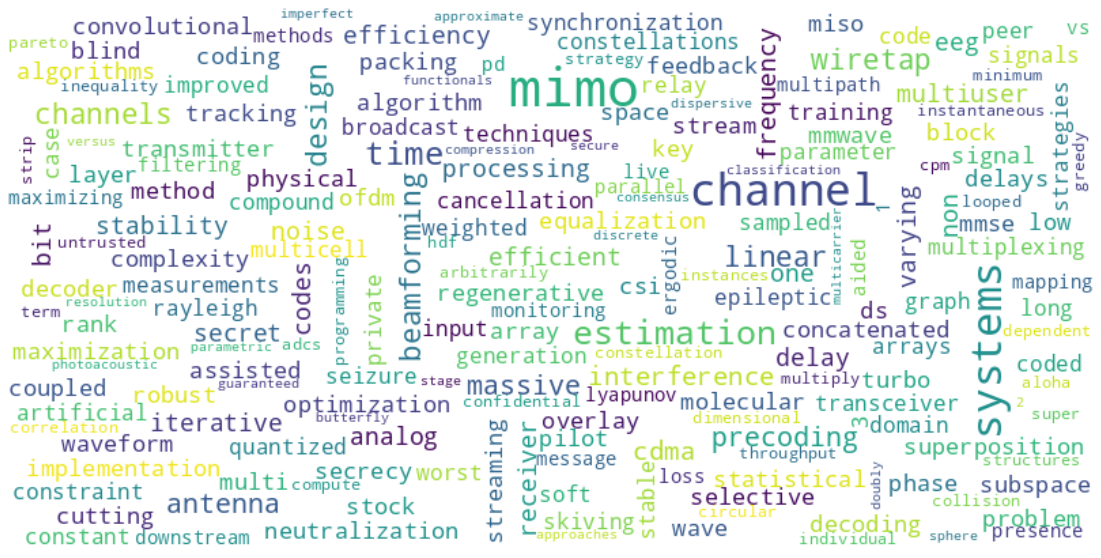

In [167]:
d2 = t2b.merge(t1b, on = 'kw',how='outer').fillna(0)
d2 = d2.where(~ d2.isin(eng_stop)).dropna()
d2['cnt_diff'] = d2['cnt_x'] - d2['cnt_y']
d2['normalized_diff'] = d2['normalized_x'] - d2['normalized_y']
display(d2.sort_values('normalized_diff',ascending= False).head(n= 20))
plot_ala(d2)

kw  cnt_x  normalized_x   cnt_y  normalized_y  cnt_diff  \
7            mimo  452.0      0.014613   861.0      0.007862    -409.0   
10        channel  363.0      0.011736   813.0      0.007424    -450.0   
8         systems  436.0      0.014096  1138.0      0.010392    -702.0   
18     estimation  167.0      0.005399   351.0      0.003205    -184.0   
24           time  153.0      0.004946   314.0      0.002867    -161.0   
54         linear   87.0      0.002813   136.0      0.001242     -49.0   
61        wiretap   79.0      0.002554   113.0      0.001032     -34.0   
12       channels  302.0      0.009764   904.0      0.008255    -602.0   
25         design  146.0      0.004720   357.0      0.003260    -211.0   
46    beamforming   96.0      0.003104   186.0      0.001698     -90.0   
33        massive  126.0      0.004074   308.0      0.002813    -182.0   
50        antenna   92.0      0.002974   188.0      0.001717     -96.0   
70      precoding   71.0      0.002295   115.0      0.001050     -44.0   
17   interference  180.0      0.005819   508.0      0.004639    -328.0   
41           cdma  108.0      0.003492   254.0      0.002319    -146.0   
19      efficient  165.0      0.005334   470.0      0.004292    -305.0   
107       varying   47.0      0.001520    55.0      0.000502      -8.0   
130     stability   38.0      0.001229    24.0      0.000219      14.0   
108           one   47.0      0.001520    62.0      0.000566     -15.0   
95            bit   55.0      0.001778    91.0      0.000831     -36.0   

     normalized_diff  
7           0.006751  
10          0.004312  
8           0.003704  
18          0.002194  
24          0.002079  
54          0.001571  
61          0.001522  
12          0.001509  
25          0.001460  
46          0.001405  
33          0.001261  
50          0.001258  
70          0.001245  
17          0.001181  
41          0.001172  
19          0.001043  
107         0.001017  
130         0.001009  
108         0.000953  
95          0.000947

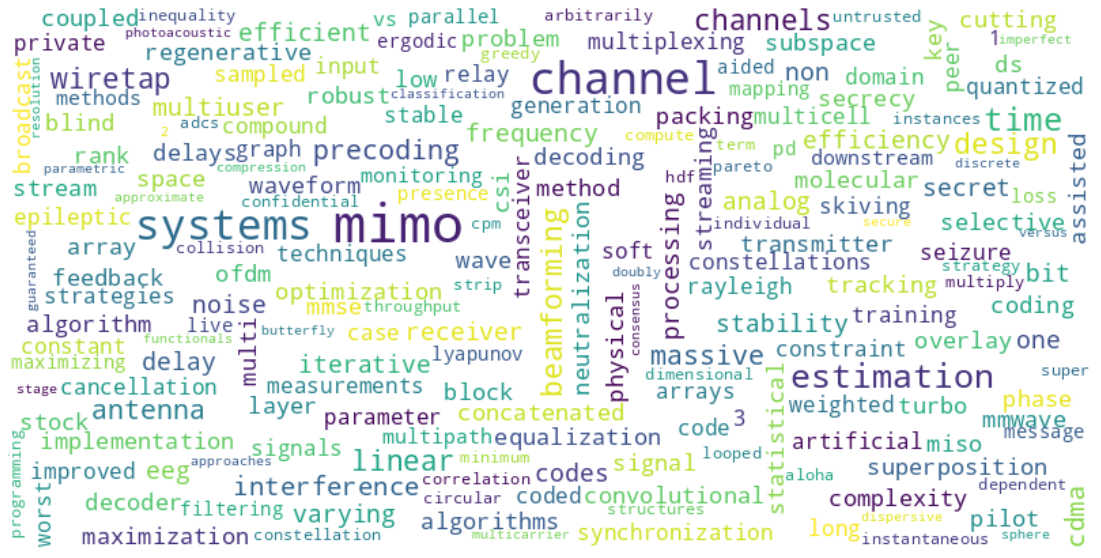

In [174]:
di = ti.merge(t12, on = 'kw',how='outer').fillna(0)
di = d2.where(~ d2.isin(eng_stop)).dropna()
di['cnt_diff'] = d2['cnt_x'] - d2['cnt_y']
di['normalized_diff'] = d2['normalized_x'] - d2['normalized_y']
display(di.sort_values('normalized_diff',ascending= False).head(n= 20))
plot_ala(di)